<a href="https://colab.research.google.com/github/rzagni/rzagni.github.com/blob/main/DeepLearning/TC5033_Activity2b_Team56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Advanced Machine Learning Methods**
###**Tecnológico de Monterrey**
###**Prof José Antonio Cantoral Ceballos**


###**Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch**

#### **Team 56:**

* Daniel Ruiz Gutiérrez A01100513
* José Manuel GarcÍa Ogarrio A01795147
* Miriam Bönsch A01330346
* Raul Eduardo Gomez Godinez A01795214
* Renzo Zagni A01795457
* Roger Alexei Urrutia ParKer A01362405


# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
# from jupyterthemes import jtplot
# jtplot.style()

### Download Cifar10 dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/DL/A2B')

In [8]:
DATA_PATH = '.'
NUM_TRAIN = 50000
NUM_VAL = 5000
MINIBATCH_SIZE = 32

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH,
                                 train=True,
                                 download=True,
                                 transform=transform_cifar)

train_loader = DataLoader(cifar10_train,
                          batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation & Test sets
cifar10_val_test = datasets.CIFAR10(DATA_PATH,
                                    train=False,
                                    download=True,
                                    transform=transform_cifar)

val_loader = DataLoader(cifar10_val_test,
                        batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(0, NUM_VAL)))

test_loader = DataLoader(cifar10_val_test,
                         batch_size=MINIBATCH_SIZE,
                         sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_val_test))))

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader.batch_size

32

In [10]:
val_loader.sampler.indices

range(0, 5000)

In [11]:
test_loader.sampler.indices

range(5000, 10000)

In [12]:
for index, data in enumerate(train_loader):
            xi, yi = data
            print(f'y.size: {yi.size(0)}')
            print(f'yi full: {yi.dtype}')
            print(f'xi: {xi[0].dtype}')
            print(f'yi: {yi[0]}')
            print(f'data: {data[1][0]}')
            break

y.size: 32
yi full: torch.int64
xi: torch.float32
yi: 6
data: 6


### Using  GPUs

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: ship


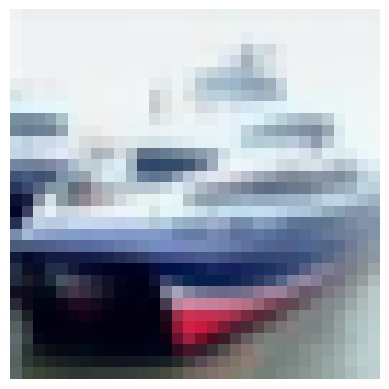

In [14]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


In [15]:
image.shape

torch.Size([3, 32, 32])

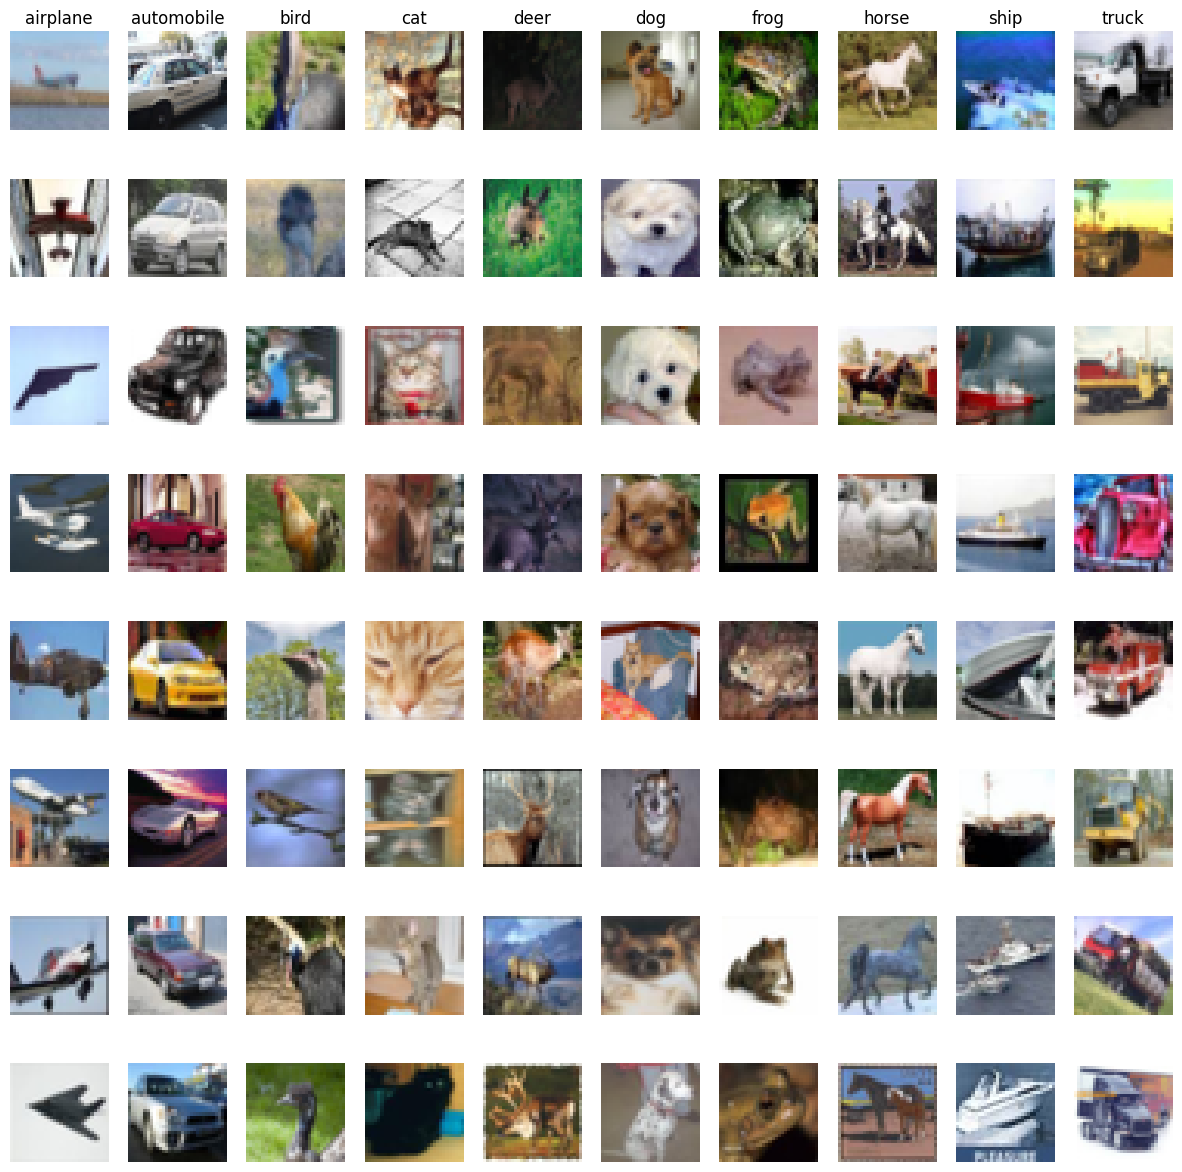

In [16]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()

### Calcular accuracy


In [17]:
def accuracy(model, loader):
    """
    Computes the accuracy of a given PyTorch model on a dataset provided by a
    DataLoader.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to evaluate. This model should be an instance of a
        neural network model class.
    loader : torch.utils.data.DataLoader
        The DataLoader object providing batches of input data (features) and
        corresponding labels.

    Returns:
    --------
    float
        The accuracy of the model on the dataset as a floating-point value,
        representing the proportion of correct predictions.

    Description:
    ------------
    1. The model is set to evaluation mode using `model.eval()`. This ensures
       that layers like dropout and batch normalization work in inference mode.
    2. The model is moved to the appropriate device (usually CPU or GPU) as
       specified by the global variable `device`.
    3. `torch.no_grad()` is used to disable gradient calculation, which reduces
        memory consumption and speeds up computations during inference.
    4. The DataLoader `loader` iterates over the dataset, providing input data
       (`xi`) and corresponding labels (`yi`):
        - The input data `xi` is cast to the appropriate device and data type
          (float32).
        - The labels `yi` are cast to the appropriate device and data type (long
          for classification tasks).
    5. The model makes predictions (scores) on the input data `xi`.
       The `scores.max(dim=1)` function returns both the maximum score and the
    predicted label (`pred`).
    6. The number of correct predictions (`num_correct`) is updated by comparing
       `pred` to the true labels `yi`.
    7. The total number of predictions (`num_total`) is incremented based on the
       batch size (`pred.size(0)`).
    8. The function returns the accuracy as the ratio of `num_correct` to
      `num_total` as a floating-point value.

    Example:
    --------
    accuracy_value = accuracy(trained_model, test_loader)
    print(f'Accuracy: {accuracy_value:.4f}')
    """
    num_correct = 0
    num_total = 0
    cost = 0.0
    model.eval()
    model = model.to(device=device)

    with torch.no_grad():
        for data in loader:
            xi, yi = data
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
    return float(num_correct/num_total)


### Loop de entrenamiento

In [19]:
def train(model, optimizer, epochs=100):
    """
    Trains a PyTorch model using the specified optimizer for a given number
    of epochs.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer to use for updating the model's parameters.
    epochs : int, optional
        Number of training epochs. Default is 100.

    Description:
    ------------
    1. The model is moved to the device specified by the global `device`.
    2. Training runs for the number of epochs specified by `epochs`.
    3. Each batch of training data (xi, yi) from `train_loader` is processed:
       - `xi` (features) is moved to the device and converted to `float32`.
       - `yi` (labels) is moved to the device and converted to `long`.
       - The model is set to training mode using `model.train()`.
       - Forward pass: the model computes `scores` based on `xi`.
       - The cross-entropy loss (cost) is calculated between `scores` and `yi`.
       - Gradients are computed via `cost.backward()`.
       - The optimizer updates model parameters via `optimizer.step()`.
       - Gradients are reset using `optimizer.zero_grad()`.
    4. Every `prt_every` epochs, the accuracy of the model on the validation
       set (`val_loader`) is printed along with the current loss.

    Returns:
    --------
    None

    Example:
    --------
    train(trained_model, optimizer, epochs=50)
    """

    prt_every = 5 # Print output every N epochs
    model = model.to(device=device)
    for epoch in range(1, epochs + 1):
        for data in train_loader:
            xi, yi = data
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            model.train()
            scores = model(xi)
            cost = F.cross_entropy(input=scores, target=yi)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        if not epoch % prt_every:
            acc = accuracy(model, val_loader)
            print(f'Epoch: {epoch}, Costo: {cost.item()}, Accuracy: {acc}')

### Linear model

In [27]:
# To do: Use PyTorch to create a linear model to have an initial baseline model

# Define the input size for the model
N = 3 * 32 * 32  # Input image size (3 channels, 32x32 pixels)

# Define the size of hidden layers
hidden1 = 1000
hidden2 = 800
hidden3 = 1000

# Learning rate and number of training epochs
learning_rate = 0.0125
epochs = 50

# Model Architecture
modelo = nn.Sequential(
    nn.Flatten(),  # Flattens the input from (batch_size, 3, 32, 32) to (batch_size, N)
    nn.Linear(in_features=N, out_features=hidden1),  # First hidden layer
    nn.ReLU(),  # Activation function
    nn.Linear(in_features=hidden1, out_features=hidden2),  # Second hidden layer
    nn.ReLU(),  # Activation function
    nn.Linear(in_features=hidden2, out_features=hidden3),  # Third hidden layer
    nn.ReLU(),  # Activation function
    nn.Linear(in_features=hidden3, out_features=10)  # Output layer (10 classes)
)

# Optimizer definition
optimizer = torch.optim.SGD(modelo.parameters(), lr=learning_rate)

# Train the model
train(modelo, optimizer, epochs)



Epoch: 5, Costo: 1.2078709602355957, Accuracy: 0.5415999889373779
Epoch: 10, Costo: 0.7057857513427734, Accuracy: 0.5541999936103821
Epoch: 15, Costo: 1.2544609308242798, Accuracy: 0.5157999992370605
Epoch: 20, Costo: 1.0847561359405518, Accuracy: 0.5342000126838684
Epoch: 25, Costo: 0.08809904754161835, Accuracy: 0.5511999726295471
Epoch: 30, Costo: 0.40072110295295715, Accuracy: 0.5429999828338623
Epoch: 35, Costo: 0.027516961097717285, Accuracy: 0.5573999881744385
Epoch: 40, Costo: 0.010634914971888065, Accuracy: 0.5555999875068665
Epoch: 45, Costo: 0.003494811477139592, Accuracy: 0.5607999563217163
Epoch: 50, Costo: 0.00022929736587684602, Accuracy: 0.5773999691009521


### Calculate Trained Model Accuracy with Test Dataset

In [21]:
print(f'Accuracy: {accuracy(modelo, test_loader)}')

Accuracy: 0.5763999819755554


###Test model with a random image

In [22]:
# Define a reusable function
def display_rnd_pred(model):
    """
    Randomly samples an image from the test dataset, performs inference using
    the provided model, and displays the image along with the predicted and
    true class labels.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained PyTorch model to use for prediction.

    Returns:
    --------
    None
        The function displays the image along with the predicted and true labels.

    Description:
    ------------
    1. The model is set to evaluation mode (`model.eval()`).
    2. A random image from the test dataset is selected, and inference is
       performed to predict its class.
    3. The predicted and true class names are displayed, along with the image.
    4. The image is de-normalized and displayed

    Example:
    --------
    display_rnd_pred(modeloCNN)
    """
    model.eval()  # Set model to evaluation mode

    # Randomly sample an image from the test dataset
    sample_idx = torch.randint(len(test_loader.dataset), size=(1,)).item()
    image, true_label = test_loader.dataset[sample_idx]

    # Move the image to the correct device and add a batch dimension
    image = image.to(device).unsqueeze(0)  # Add batch dimension for inference

    # Perform forward pass without calculating gradients
    with torch.no_grad():
        outputs = model(image)

    # Get the predicted class
    _, predicted_label = outputs.max(1)

    # Convert prediction and true label to class names
    predicted_class = test_loader.dataset.classes[predicted_label.item()]
    true_class = test_loader.dataset.classes[true_label]

    # Display the image and the prediction
    image = torch.clamp(image, 0, 1)  # Clamp the image to valid pixel range
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    plt.title(f'Predicted Class: {predicted_class}, Actual Class: {true_class}')
    plt.show()


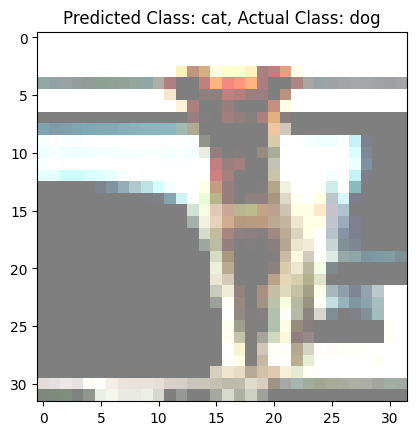

In [23]:
display_rnd_pred(modelo)

### Sequential CNN

In [24]:
# To do: Use PyTorch to implement a CNN model, accuracy should be better than
# the linear model
# Define input dimensions and model parameters
N = 3 * 32 * 32  # Input image size (3 channels, 32x32 pixels)
channel1 = 128  # Number of filters in the first convolutional layer
channel2 = 256  # Number of filters in the second convolutional layer
channel3 = 512  # Number of filters in the third convolutional layer
hidden1 = 128   # Number of neurons in the first fully connected layer
learning_rate = 0.01  # Learning rate for the optimizer
epochs = 50  # Number of training epochs

# Model architecture: A Convolutional Neural Network (CNN)
modeloCNN = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
    nn.ReLU(),  # Activation function after the first convolution
    nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
    nn.ReLU(),  # Activation function after the second convolution
    nn.Conv2d(in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
    nn.ReLU(),  # Activation function after the third convolution
    nn.MaxPool2d(2, 2),  # Pooling layer to downsample the feature maps by 2
    nn.Flatten(),  # Flattens the feature maps into a 1D vector
    nn.Linear(in_features=16 * 16 * channel3, out_features=hidden1),  # First fully connected layer
    nn.ReLU(),  # Activation function after the fully connected layer
    nn.Linear(in_features=hidden1, out_features=10)  # Output layer with 10 classes
)

# Optimizer setup using stochastic gradient descent (SGD)
optimizer = torch.optim.SGD(modeloCNN.parameters(), lr=learning_rate)

# Train the model using the train() function
train(modeloCNN, optimizer, epochs)


Epoch: 5, Costo: 0.965529203414917, Accuracy: 0.6985999941825867
Epoch: 10, Costo: 0.06790822744369507, Accuracy: 0.712399959564209
Epoch: 15, Costo: 0.001335260458290577, Accuracy: 0.723800003528595
Epoch: 20, Costo: 0.0007906571263447404, Accuracy: 0.725600004196167
Epoch: 25, Costo: 0.000452916749054566, Accuracy: 0.727400004863739
Epoch: 30, Costo: 0.00011692356929415837, Accuracy: 0.7283999919891357
Epoch: 35, Costo: 0.00015476811677217484, Accuracy: 0.7271999716758728
Epoch: 40, Costo: 0.00018194204312749207, Accuracy: 0.7283999919891357
Epoch: 45, Costo: 0.0002145366306649521, Accuracy: 0.7281999588012695
Epoch: 50, Costo: 4.7132110921666026e-05, Accuracy: 0.7275999784469604


### Calculate Trained CNN Model Accuracy with Test Dataset

In [25]:
print(f'Accuracy: {accuracy(modeloCNN, test_loader)}')

Accuracy: 0.7261999845504761


###Test model with a random image

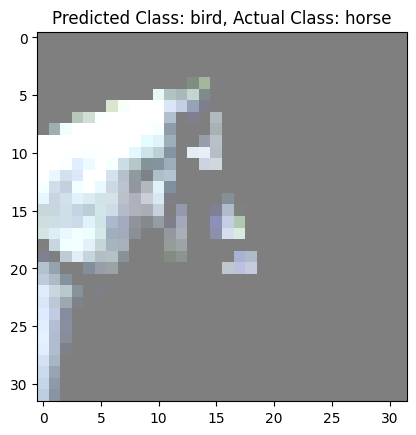

In [26]:
display_rnd_pred(modeloCNN)

**Conclusion:**

The CNN model significantly outperforms the fully connected model on the CIFAR10 dataset, achieving an accuracy of approximately 72.61% compared to the linear model's 57.10%. This improvement is attributed to the CNN's ability to capture spatial hierarchies and local patterns in images, which are crucial for image classification tasks. The convolutional layers effectively learn feature maps that represent edges, textures, and more complex patterns as the network depth increases.

The choice of architecture, including the number of layers and channels was determined heuristically as well as for recommendations and readings from the text book [1], the active sessions and the Dr. Cantoral's YouTube videos about Deep Learning [2]. The learning rate was determined by following Dr Cantoral's method described in his YouTube video and the number of epochs was determined by the reduction of the loss and the increase in accuracy.

One challenge faced was ensuring the model did not overfit the training data. Techniques such as dropout or data augmentation could be explored in future iterations to address this. Additionally, experimenting with different architectures, such as adding more layers could further enhance performance and achieve greater accuracy.

In conclusion, this exercise demonstrates the power of CNNs in handling image data and highlights the importance of architectural choices in deep learning models. The CNN's superior performance over the fully connected model underscores the need for specialized architectures tailored to the data type, in this case, images. This activity not only reinforces the theoretical understanding of CNNs but also provides practical insights into their implementation using PyTorch.



---

References:

[1] *Raschka, S., Liu, Y., & Dzhulgakov, D*. (2022). Machine Learning with Pytorch and Scikit-Learn: Develop Machine Learning and Deep Learning Models with Python. Packt Publishing.

[2] *Pepe Cantoral PhD*. (s. f.). [Vídeo]. YouTube. https://www.youtube.com/c/pepecantoralphd
